In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.graph_objects as go
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import clear_output
from statsmodels.tsa.seasonal import STL

# Load and prepare the data
file_path = 'IBM_2006-01-01_to_2018-01-01.csv'
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data.drop('Name', axis=1)


In [2]:
# Identify missing days 
all_days = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')

missing_days = all_days.difference(data.index)

missing_days_df = pd.DataFrame(missing_days, columns=['MissingDate'])
missing_days_df['DayOfWeek'] = missing_days_df['MissingDate'].dt.day_name()

print("Missing days with day of the week:")
print(missing_days_df)

pattern_analysis = missing_days_df['DayOfWeek'].value_counts()
print("\nPattern of missing days by day of the week:")
print(pattern_analysis)

Missing days with day of the week:
     MissingDate DayOfWeek
0     2006-01-07  Saturday
1     2006-01-08    Sunday
2     2006-01-14  Saturday
3     2006-01-15    Sunday
4     2006-01-16    Monday
...          ...       ...
1354  2017-12-16  Saturday
1355  2017-12-17    Sunday
1356  2017-12-23  Saturday
1357  2017-12-24    Sunday
1358  2017-12-25    Monday

[1359 rows x 2 columns]

Pattern of missing days by day of the week:
DayOfWeek
Saturday     625
Sunday       625
Monday        59
Friday        21
Thursday      17
Tuesday        8
Wednesday      4
Name: count, dtype: int64


In [3]:
# NaN values
data[data.isna().any(axis=1)]

,Open,High,Low,Close,Volume
Date,,,,,
2017-07-31,NaN,144.93,NaN,144.67,4355718


In [4]:
# cleanup
data_resampled = data.asfreq('D')
data_resampled = data_resampled.interpolate(method='time')

print(data_resampled.isna().sum())

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


# Visualization

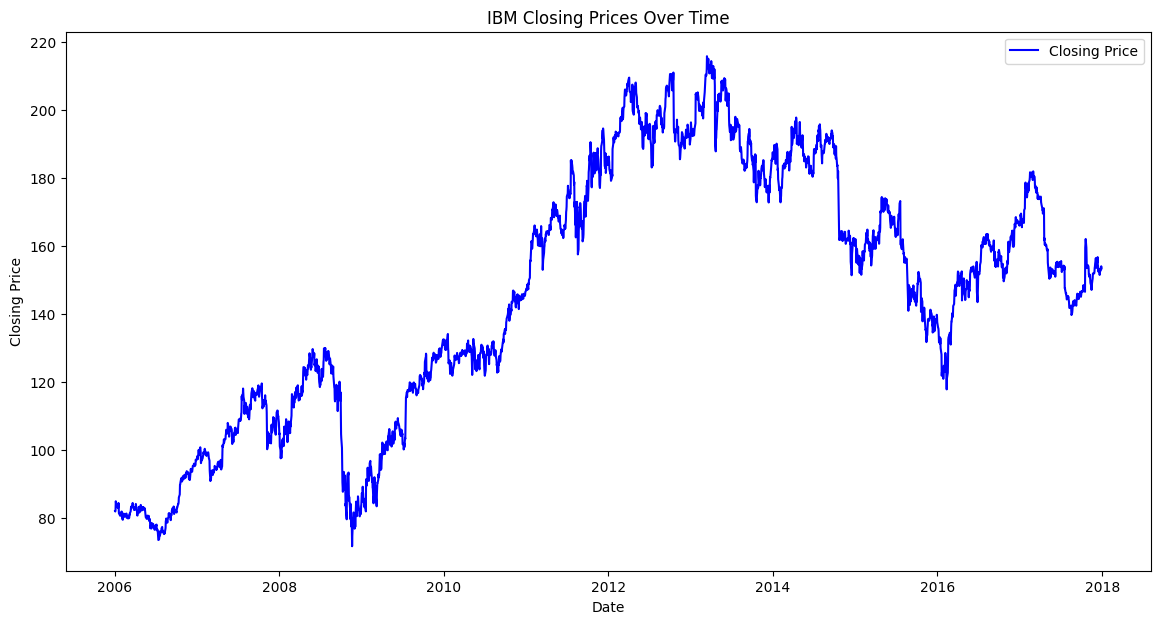

In [5]:
# 1. Visualization

plt.figure(figsize=(14, 7))
plt.plot(data['Close'], color='blue', label='Closing Price')
plt.title('IBM Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [6]:
# helper to work on selected dates only
def filter_data_by_date(data, df_callback):
    # Convert the index to integer positions for slider values
    date_range = data.index

    # Define a range slider for selecting the start and end indices
    range_slider = widgets.IntRangeSlider(
        value=[0, len(date_range) - 1],
        min=0,
        max=len(date_range) - 1,
        step=1,
        description='Date Range',
        continuous_update=False
    )

    # Display the slider widget
    display(range_slider)

    # Display the actual date range selected for clarity
    date_display = widgets.Label(
        value=f"Selected Range: {date_range[range_slider.value[0]].strftime('%d-%m-%Y')} to {date_range[range_slider.value[1]].strftime('%d-%m-%Y')}"
    )
    display(date_display)

    # Update the date display when the slider value changes
    def update_date_display(*args):
        date_display.value = f"Selected Range: {date_range[range_slider.value[0]].strftime('%d-%m-%Y')} to {date_range[range_slider.value[1]].strftime('%d-%m-%Y')}"
        start_idx, end_idx = range_slider.value
        filtered_df = data.iloc[start_idx:end_idx + 1]
        clear_output(wait=True)
        display(range_slider, date_display)
        df_callback(filtered_df.copy())

    range_slider.observe(update_date_display, 'value')

In [7]:
# candlesticks and volume

def candlesticks(data):
    # Create a candlestick chart
    fig = go.Figure()

    # Add volume as a bar chart on a secondary y-axis
    fig.add_trace(go.Bar(
        x=data.index,
        y=data['Volume'],
        name='Volume',
        marker=dict(color='rgba(128, 128, 128, 0.5)'),
    ))

    fig.add_trace(go.Candlestick(
        x=data.index,
        open=data['Open'],
        high=data['High'],
        low=data['Low'],
        close=data['Close'],
        name='Candlestick',
        yaxis="y2"
    ))

    # Update layout to include a secondary y-axis for volume
    fig.update_layout(
        title="IBM Stock Candlestick Chart with Volume",
        xaxis_title="Date",
        yaxis_title="Volume",
        yaxis2=dict(
            title="Price",
            overlaying="y",
            side="right"
        ),
        xaxis_rangeslider_visible=False  # Hide the default range slider
    )

    # Show the figure
    fig.show()

filter_data_by_date(data, candlesticks)

IntRangeSlider(value=(0, 3019), continuous_update=False, description='Date Range', max=3019)

Label(value='Selected Range: 03-01-2006 to 29-12-2017')

# Observations from data

- no obvious patterns (who would have known)
- huge drop 20 oct 2014: https://www.wired.com/2014/10/ibm-globalfoundries/
- abnormal situations often associated with high trade volume

In [8]:
# try finding best period minimizing mse
def find_optimal_period(data, min_period=7, max_period=365):
    mse_values = []
    periods = range(min_period, max_period + 1, 7)

    for period in periods:
        stl = STL(data['Close'], period=period, robust=False)  # Choose 'seasonal' parameter based on testing
        decomposition = stl.fit()

        # decomposition = seasonal_decompose(data['Close'], model='additive', period=period)

        residuals = decomposition.resid
        mse = np.nanmean(residuals ** 2)  # Calculate MSE, ignoring NaN values
        mse_values.append((period, mse))

    # Find the period with the minimum MSE
    best_period = min(mse_values, key=lambda x: x[1])[0]
    fig = go.Figure()

    # Add line plot
    fig.add_trace(go.Scatter(x=list(periods), y=[x[1] for x in mse_values], mode='lines+markers', name='MSE'))


    # Highlight the best period on the plot
    fig.add_trace(go.Scatter(
        x=[best_period],
        y=[min([x[1] for x in mse_values])],
        mode='markers+text',
        text=[f"Best Period: {best_period}"],
        textposition='top center',
        marker=dict(color='red', size=10),
        name='Optimal Period'
    ))

    # Update plot layout
    fig.update_layout(
        title="Mean Squared Error of Residuals vs. Period",
        xaxis_title="Period",
        yaxis_title="Mean Squared Error (MSE)",
        xaxis=dict(showgrid=True, gridcolor="lightgray", gridwidth=0.5),
    )
    fig.show()

    # Print and return results
    print(f"Best Period: {best_period}, Minimum MSE: {min([x[1] for x in mse_values])}")
    return best_period, mse_values


best_period, mse_values = find_optimal_period(data_resampled)

# filter_data_by_date(data_resampled, find_optimal_period)


Best Period: 7, Minimum MSE: 1.0849858277306548


MSE: 1.08


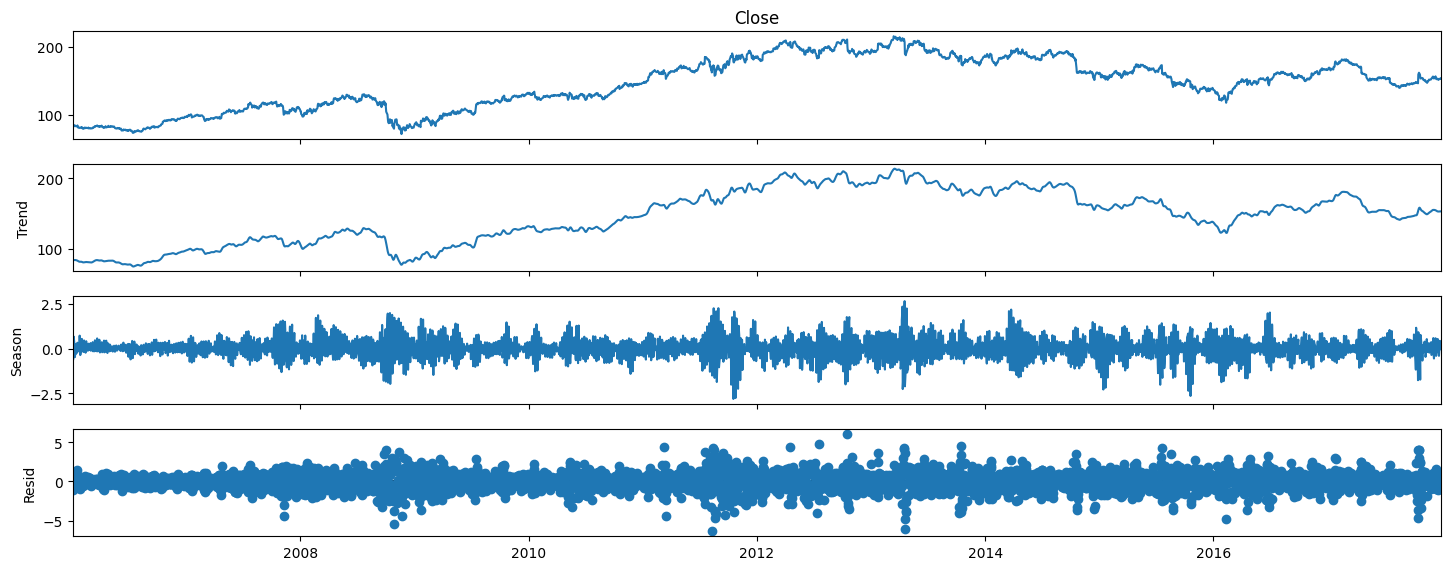

In [9]:
def plot_decomposition(data, period):
    # Set period (e.g., 21 trading days for a month)
    stl = STL(data['Close'], period=period, robust=False)  # Choose 'seasonal' parameter based on testing
    result = stl.fit()

    # Plotting the components
    mse = np.nanmean(result.resid ** 2)  # Calculate MSE, ignoring NaN values
    fig = result.plot()
    fig.set_size_inches(16, 6)
    print(f'MSE: {mse:.2f}')
    plt.show()

def plot_decomposition_interactive(data):
    # Create an interactive slider for period (min, max, step)
    interact(lambda period: plot_decomposition(data, period), period=widgets.IntSlider(min=2, max=365, step=1, value=25))

plot_decomposition(data_resampled, period=7)


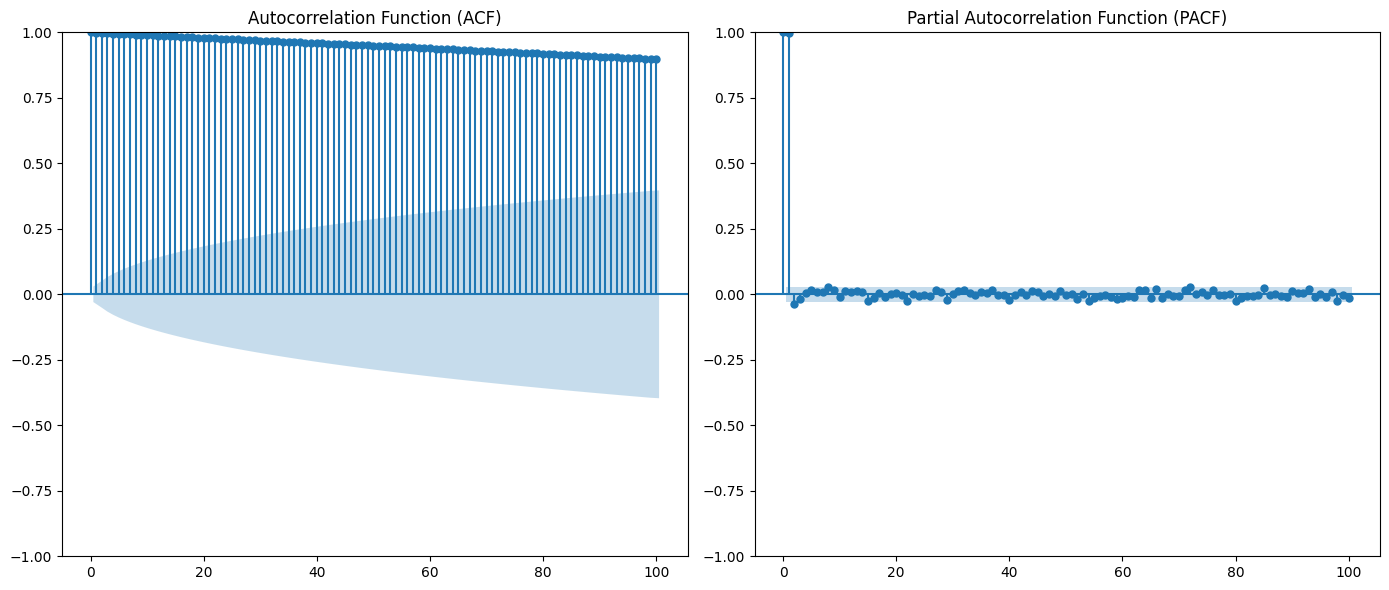

In [10]:
def acf_analysis(data):
    # Autocorrelation Analysis
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plot_acf(data, lags=100, ax=plt.gca())
    plt.title('Autocorrelation Function (ACF)')
    plt.subplot(1, 2, 2)
    plot_pacf(data, lags=100, ax=plt.gca(), method='ywm')
    plt.title('Partial Autocorrelation Function (PACF)')
    plt.tight_layout()
    plt.show()

acf_analysis(data_resampled['Close'])

# OUTLIERS


In [11]:
def detect_outliers_with_best_period(data, period, threshold=3):

    # Perform STL decomposition
    stl = STL(data['Close'], period=period, robust=True)
    result = stl.fit()

    # Extract residuals
    residuals = result.resid

    # Calculate mean and standard deviation of residuals
    mean_resid = np.mean(residuals)
    std_resid = np.std(residuals)

    # Detect outliers
    outliers = residuals[(residuals > mean_resid + threshold * std_resid) |
                         (residuals < mean_resid - threshold * std_resid)].index

    # Visualize residuals and outliers
    plt.figure(figsize=(14, 6))
    plt.plot(residuals, label='Residuals', alpha=0.7)
    plt.scatter(outliers, residuals[outliers], color='red', label='Outliers')
    plt.axhline(mean_resid + threshold * std_resid, color='orange', linestyle='--', label='Threshold')
    plt.axhline(mean_resid - threshold * std_resid, color='orange', linestyle='--')
    plt.title("Residuals and Detected Outliers")
    plt.legend()
    plt.show()

    return outliers, result

In [12]:
def replace_outliers_with_trend(data, outliers, trend):

    adjusted_data = data.copy()
    adjusted_data[outliers] = trend[outliers]
    return adjusted_data

In [13]:
def stl_outlier_detection_and_removal(data, period, threshold=3):
  
    # Detect outliers
    outliers, result = detect_outliers_with_best_period(data, period, threshold)

    # Replace outliers with trend values
    adjusted_data = replace_outliers_with_trend(data['Close'], outliers, result.trend)

    # Plot original vs adjusted data
    plt.figure(figsize=(14, 6))
    plt.plot(data['Close'], label='Original Data', alpha=0.7)
    plt.plot(adjusted_data, label='Adjusted Data (Outliers Replaced)', linestyle='--', color='red')
    plt.title("Original vs Adjusted Data")
    plt.legend()
    plt.show()

    return adjusted_data


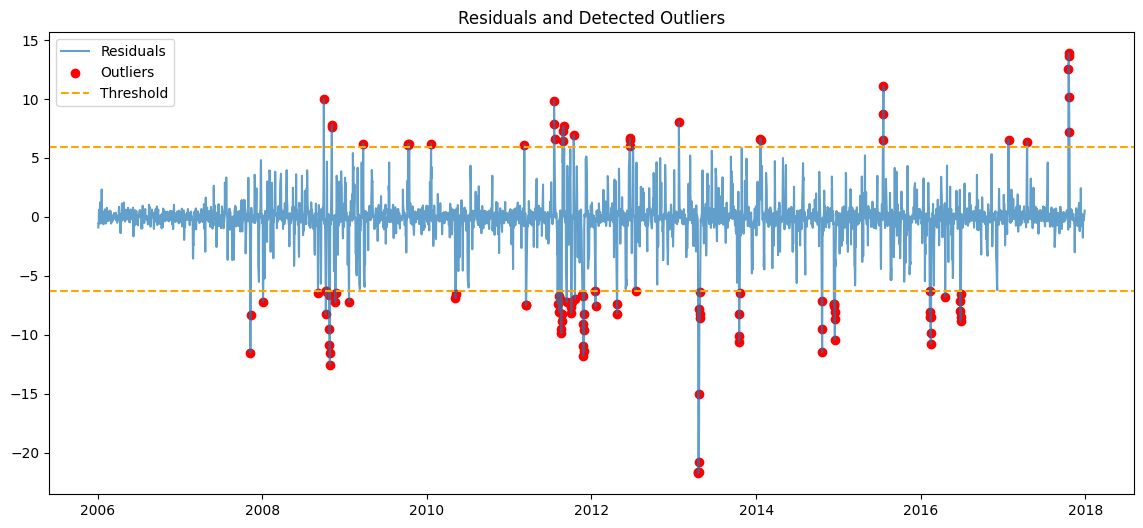

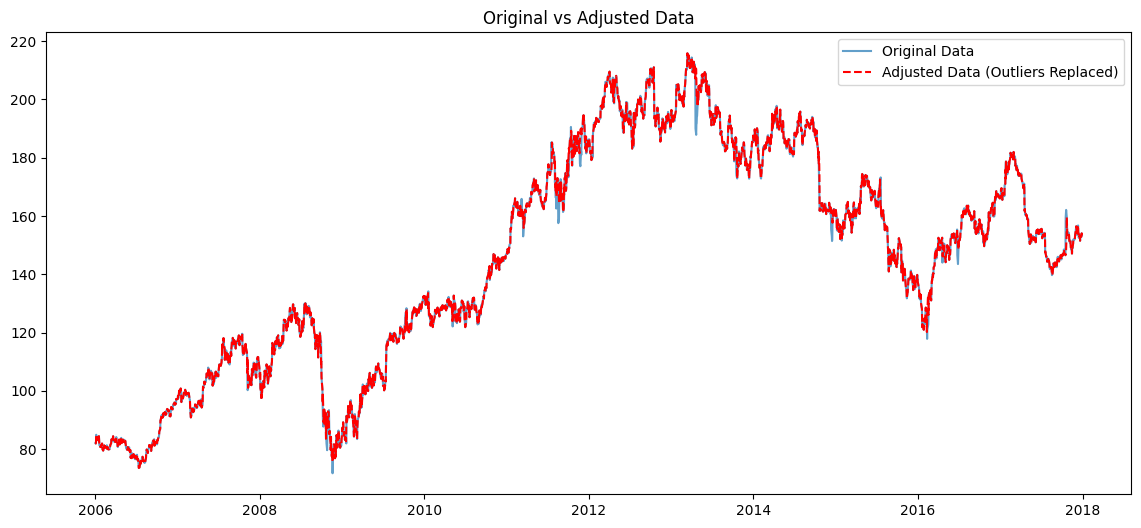

In [14]:

best_period = 7  
threshold = 3  

adjusted_data = stl_outlier_detection_and_removal(data_resampled, best_period, threshold)


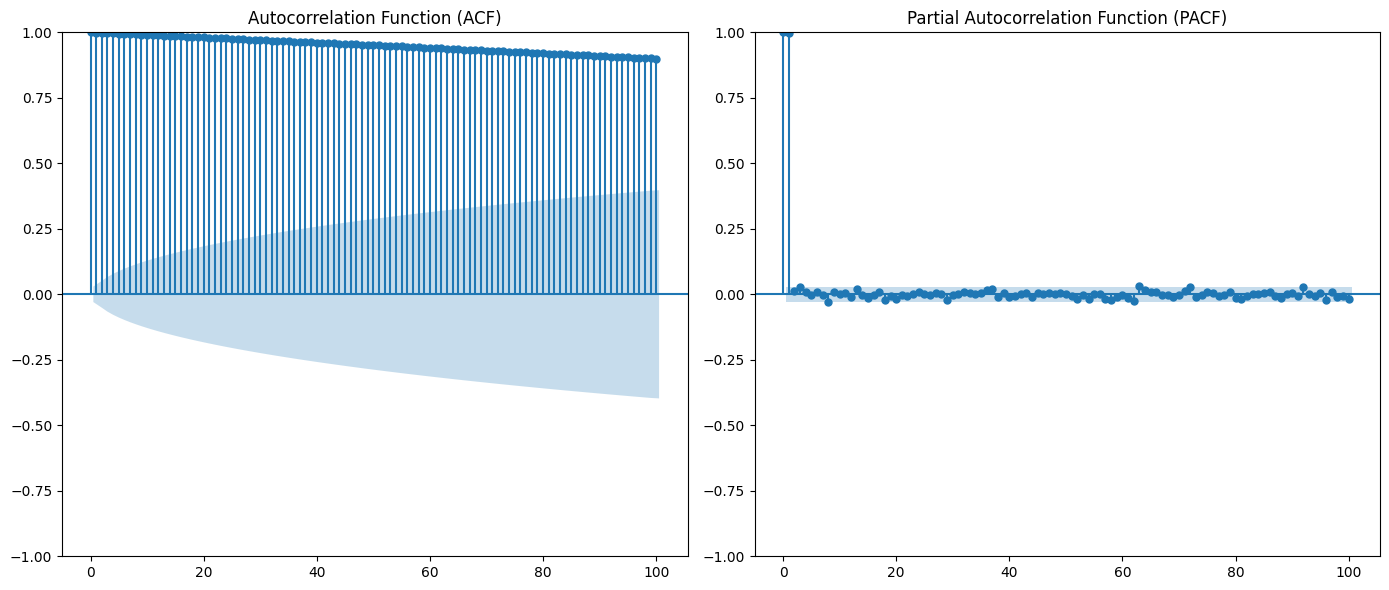

In [15]:
# ACF AND PACF after outlier removal


acf_analysis(adjusted_data)


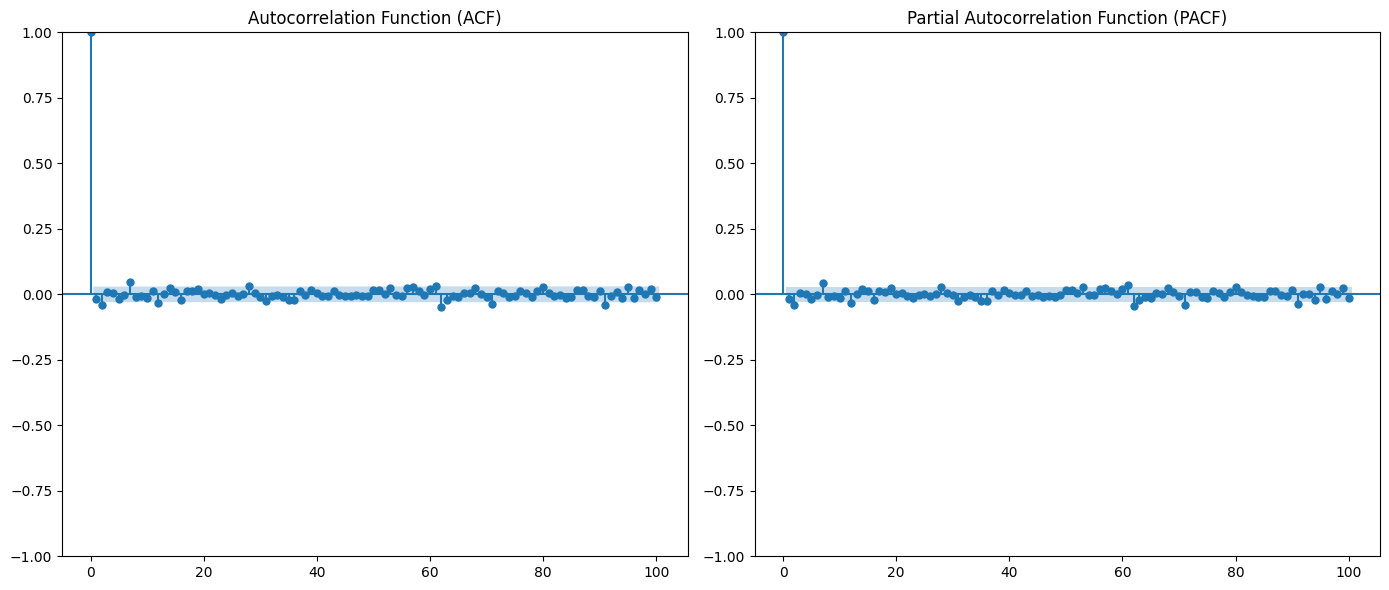

In [16]:
def acf_diff(data):
    data_diff = data.diff().dropna()
    # Autocorrelation Analysis
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plot_acf(data_diff, lags=100, ax=plt.gca())
    plt.title('Autocorrelation Function (ACF)')
    plt.subplot(1, 2, 2)
    plot_pacf(data_diff, lags=100, ax=plt.gca(), method='ywm')
    plt.title('Partial Autocorrelation Function (PACF)')
    plt.tight_layout()
    plt.show()

acf_diff(adjusted_data)


# AR model

In [17]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

close_prices = adjusted_data.values  # data after outlier adjust

T = 7  # Lag period 
epochs = 50
batch_size = 32

# Prepare the dataset
X, Y = [], []
for t in range(len(close_prices) - T):
    X.append(close_prices[t:t + T])  
    Y.append(close_prices[t + T])   

X = np.array(X)
Y = np.array(Y)

print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (4372, 7) Y.shape (4372,)


In [18]:
# Define Time Series Split
tscv = TimeSeriesSplit(n_splits=5)  # 5-fold cross-validation
split_results = []

Epoch 1/50
23/23 [==============================] - 2s 19ms/step - loss: 1019.1580 - val_loss: 4.6353
Epoch 2/50
23/23 [==============================] - 0s 5ms/step - loss: 34.7045 - val_loss: 16.8101
Epoch 3/50
23/23 [==============================] - 0s 6ms/step - loss: 6.2835 - val_loss: 5.3248
Epoch 4/50
23/23 [==============================] - 0s 6ms/step - loss: 1.9713 - val_loss: 4.6528
Epoch 5/50
23/23 [==============================] - 0s 7ms/step - loss: 1.8508 - val_loss: 4.3582
Epoch 6/50
23/23 [==============================] - 0s 6ms/step - loss: 1.8254 - val_loss: 4.5781
Epoch 7/50
23/23 [==============================] - 0s 6ms/step - loss: 1.8360 - val_loss: 4.3694
Epoch 8/50
23/23 [==============================] - 0s 6ms/step - loss: 1.8200 - val_loss: 4.3358
Epoch 9/50
23/23 [==============================] - 0s 6ms/step - loss: 1.8053 - val_loss: 4.3252
Epoch 10/50
23/23 [==============================] - 0s 6ms/step - loss: 1.8799 - val_loss: 5.1370
Epoch 11/50
2

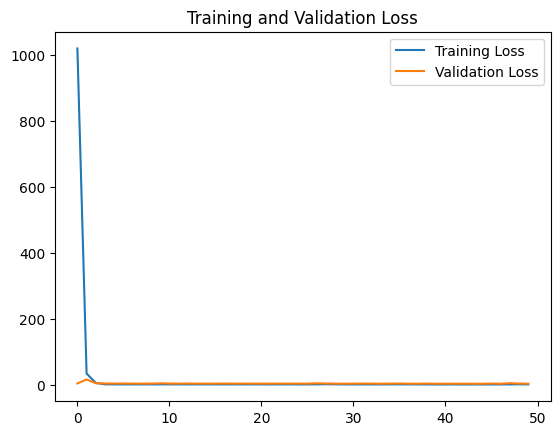

Epoch 1/50
46/46 [==============================] - 4s 25ms/step - loss: 810.2750 - val_loss: 12.0439
Epoch 2/50
46/46 [==============================] - 0s 10ms/step - loss: 8.5936 - val_loss: 6.7858
Epoch 3/50
46/46 [==============================] - 0s 9ms/step - loss: 5.6346 - val_loss: 6.7384
Epoch 4/50
46/46 [==============================] - 0s 10ms/step - loss: 5.6218 - val_loss: 6.8055
Epoch 5/50
46/46 [==============================] - 0s 10ms/step - loss: 5.5724 - val_loss: 6.8812
Epoch 6/50
46/46 [==============================] - 0s 10ms/step - loss: 5.6689 - val_loss: 6.7006
Epoch 7/50
46/46 [==============================] - 1s 12ms/step - loss: 5.4834 - val_loss: 6.7390
Epoch 8/50
46/46 [==============================] - 1s 17ms/step - loss: 5.4468 - val_loss: 7.2852
Epoch 9/50
46/46 [==============================] - 0s 10ms/step - loss: 5.3126 - val_loss: 7.0351
Epoch 10/50
46/46 [==============================] - 0s 10ms/step - loss: 5.6074 - val_loss: 6.7909
Epoch 1

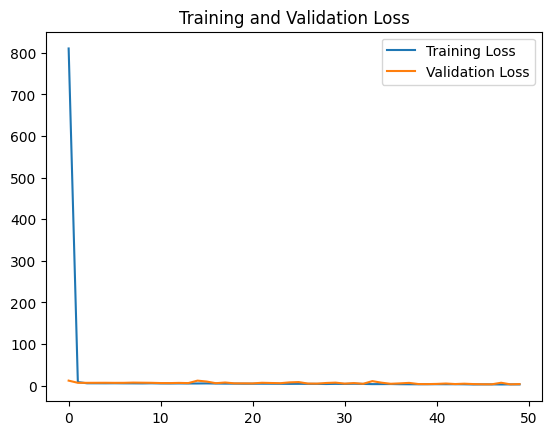

Epoch 1/50
69/69 [==============================] - 2s 8ms/step - loss: 650.2422 - val_loss: 7.6692
Epoch 2/50
69/69 [==============================] - 0s 4ms/step - loss: 4.7296 - val_loss: 6.6485
Epoch 3/50
69/69 [==============================] - 0s 3ms/step - loss: 4.2399 - val_loss: 6.8854
Epoch 4/50
69/69 [==============================] - 0s 3ms/step - loss: 4.3549 - val_loss: 6.5999
Epoch 5/50
69/69 [==============================] - 0s 3ms/step - loss: 4.2384 - val_loss: 7.3543
Epoch 6/50
69/69 [==============================] - 0s 3ms/step - loss: 4.3114 - val_loss: 7.1109
Epoch 7/50
69/69 [==============================] - 0s 4ms/step - loss: 4.0783 - val_loss: 6.1532
Epoch 8/50
69/69 [==============================] - 0s 3ms/step - loss: 4.0145 - val_loss: 6.0264
Epoch 9/50
69/69 [==============================] - 0s 3ms/step - loss: 4.0337 - val_loss: 6.6314
Epoch 10/50
69/69 [==============================] - 0s 4ms/step - loss: 3.9391 - val_loss: 7.2417
Epoch 11/50
69/69

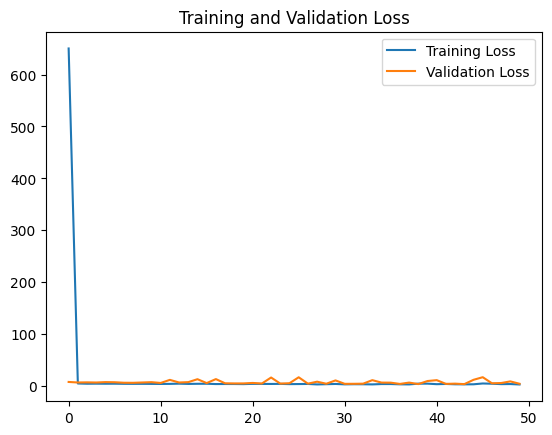

Epoch 1/50
92/92 [==============================] - 1s 4ms/step - loss: 1001.0680 - val_loss: 7.5614
Epoch 2/50
92/92 [==============================] - 0s 2ms/step - loss: 5.8542 - val_loss: 7.0746
Epoch 3/50
92/92 [==============================] - 0s 3ms/step - loss: 5.6422 - val_loss: 6.2864
Epoch 4/50
92/92 [==============================] - 0s 3ms/step - loss: 6.3178 - val_loss: 14.3659
Epoch 5/50
92/92 [==============================] - 0s 3ms/step - loss: 6.3803 - val_loss: 6.0965
Epoch 6/50
92/92 [==============================] - 0s 3ms/step - loss: 5.6923 - val_loss: 16.1781
Epoch 7/50
92/92 [==============================] - 0s 5ms/step - loss: 6.0082 - val_loss: 5.9938
Epoch 8/50
92/92 [==============================] - 0s 4ms/step - loss: 5.2891 - val_loss: 6.0165
Epoch 9/50
92/92 [==============================] - 0s 3ms/step - loss: 4.9988 - val_loss: 5.5112
Epoch 10/50
92/92 [==============================] - 0s 3ms/step - loss: 5.1739 - val_loss: 6.7483
Epoch 11/50
92

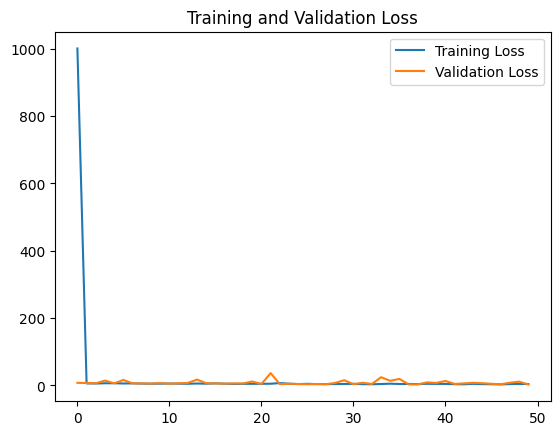

Epoch 1/50
114/114 [==============================] - 2s 9ms/step - loss: 77.3926 - val_loss: 3.9822
Epoch 2/50
114/114 [==============================] - 1s 6ms/step - loss: 5.5415 - val_loss: 6.2751
Epoch 3/50
114/114 [==============================] - 1s 6ms/step - loss: 5.9857 - val_loss: 3.8749
Epoch 4/50
114/114 [==============================] - 2s 14ms/step - loss: 5.4608 - val_loss: 4.2465
Epoch 5/50
114/114 [==============================] - 1s 7ms/step - loss: 5.4561 - val_loss: 3.2605
Epoch 6/50
114/114 [==============================] - 1s 5ms/step - loss: 4.7636 - val_loss: 4.2945
Epoch 7/50
114/114 [==============================] - 1s 4ms/step - loss: 4.7987 - val_loss: 3.4825
Epoch 8/50
114/114 [==============================] - 1s 5ms/step - loss: 5.1907 - val_loss: 2.5906
Epoch 9/50
114/114 [==============================] - 1s 6ms/step - loss: 5.3840 - val_loss: 3.3416
Epoch 10/50
114/114 [==============================] - 1s 6ms/step - loss: 4.4335 - val_loss: 2.75

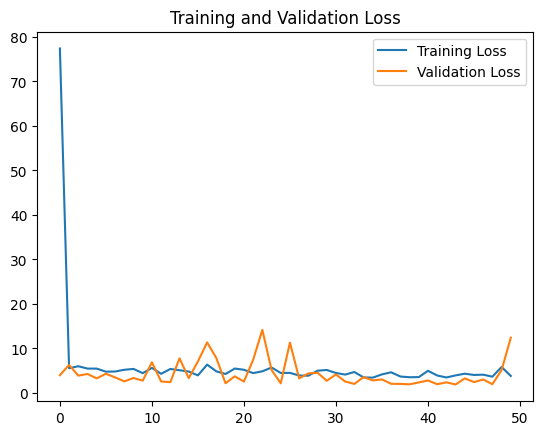

In [19]:
#  Autoregressive model define and training
for train_index, test_index in tscv.split(X):
    # Split into train and test sets
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    
    i = Input(shape=(T,))
    x = Dense(32, activation='relu')(i)  # Hidden layer 1
    x = Dense(16, activation='relu')(x)  # Hidden layer 2
    output = Dense(1)(x)  
    model = Model(i, output)
    model.compile(
        loss='mse',
        optimizer=Adam(learning_rate=0.01)
    )

    
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_test, Y_test),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )

    # Predict
    Y_pred = model.predict(X_test).reshape(-1)  # Ensure output is 1D
    mse = mean_squared_error(Y_test, Y_pred)  # Compute MSE
    split_results.append((mse, Y_test, Y_pred))

    # 6. Plot training and validation loss
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.show()



Average MSE across splits: 5.404904834612559


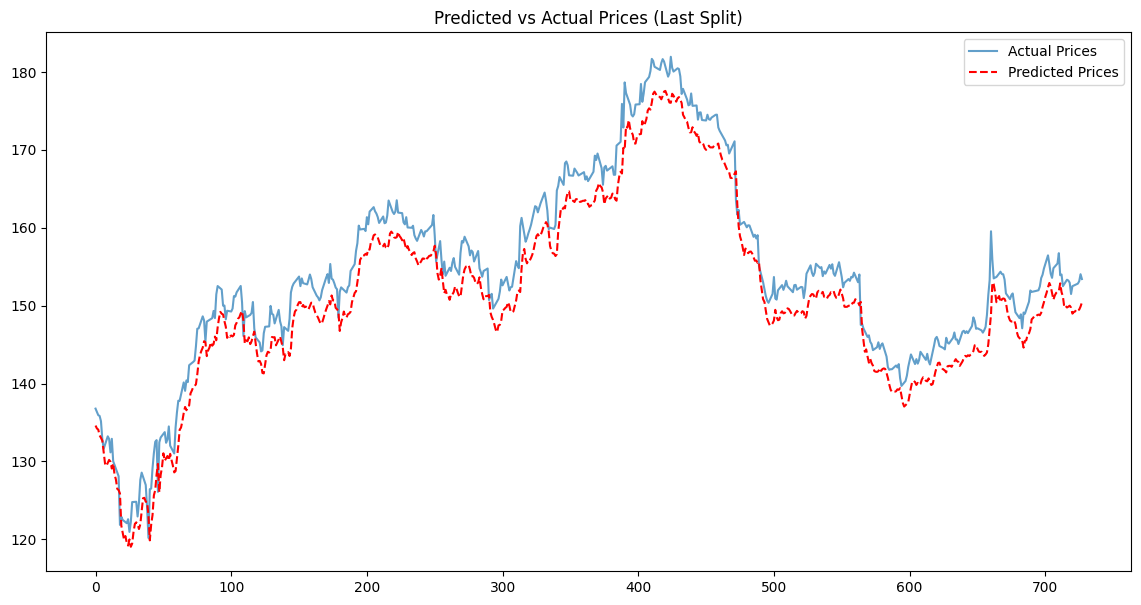

In [20]:
# Summarize results across splits
average_mse = np.mean([result[0] for result in split_results])
print(f"Average MSE across splits: {average_mse}")

# Visualize the results
Y_test_restored, Y_pred_restored = split_results[-1][1], split_results[-1][2]
plt.figure(figsize=(14, 7))
plt.plot(Y_test_restored, label="Actual Prices", alpha=0.7)
plt.plot(Y_pred_restored, label="Predicted Prices", linestyle="--", color="red")
plt.title("Predicted vs Actual Prices (Last Split)")
plt.legend()
plt.show()